# Computes PLV features for later classification

This is just a sandbox for developing DFT based PLV functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
import pandas as pd
import scipy.io as sio
import os
import sys
import ieeg_funcs as ief
import dgFuncs as dg
import pickle

In [2]:
# Block for re-loading my libraries if I make updates
import imp 
imp.reload(ief) 
imp.reload(dg) 

<module 'dgFuncs' from '/Users/davidgroppe/PycharmProjects/DG_LIBRARY/dgFuncs.py'>

In [3]:
# Import Clinician Szr Onset Times
sub='NA'
path_dict = ief.get_path_dict()
ieeg_root = path_dict['ieeg_root']

# Get list of files to use from clinician onset csv file
onset_csv_dir=path_dict['onset_csv']
onset_csv_fname=os.path.join(onset_csv_dir,sub+'_clinician_onset_offset.csv')
print('Importing file %s' % onset_csv_fname)
onset_df=pd.read_csv(onset_csv_fname)

Importing file /Users/davidgroppe/Dropbox/TWH_INFO/CLINICIAN_ONSET_TIMES/NA_clinician_onset_offset.csv


In [4]:
onset_df.head()

,DAY,SZR#,ONSET,OFFSET,SOZ_CHAN,FILE_ONSET,DDMMYR,SRATE_HZ,NOTES,ONSET_SEC,FILE_ONSET_SEC,ONSET_TPT,DG_ONSET_CHAN,USE4CLASSIFIER
0,1,1,8:59:03 PM,9:38:35 PM,?,?,06/23/2009,500,?,75543,NaN,NaN,?,noEEGdata
1,1,2,1:54:41 AM,1:55:52 AM,RHD1,1:52:45,06/23/2009,500,?,6881,6765.0,58000.0,RHD1-2,use
2,1,3,2:42:25 AM,2:43:58 AM,?,2:39:36,06/23/2009,500,?,9745,9576.0,84500.0,RHD1-2,use
3,1,4,4:51:59 AM,4:53:35 AM,?,4:49:03,06/23/2009,500,?,17519,17343.0,88000.0,RHD1-2,use
4,1,5,6:29:14 AM,6:31:11 AM,?,6:26:20,06/23/2009,500,?,23354,23180.0,87000.0,RHD1-2,use


In [5]:
def clin_onset_tpt(szr_name, onset_df):
    import re
    name_splt=szr_name.split('_')
    day=int(name_splt[1][1:])
    szr=int(re.findall('[0-9]+',name_splt[2])[0])
    print('Getting clinical onset time for %s: Day %d, Szr %d' % (name_splt[0],day,szr))

    # temp_df=onset_df[onset_df['DAY']==day and onset_df['SZR#']==2]
    day_ids=onset_df[onset_df['DAY']==day].index 
    szr_ids=onset_df[onset_df['SZR#']==szr].index 
    use_id=day_ids.intersection(szr_ids)
    onset_tpt=onset_df['ONSET_TPT'].iloc[use_id].values[0]
    return onset_tpt

szr_name='NA_d1_sz2.mat'
onset_tpt=clin_onset_tpt(szr_name, onset_df)

Getting clinical onset time for NA: Day 1, Szr 2


In [6]:
# Import data from one szr to estimate PLV

# Import channel names
chan_labels=ief.import_chan_labels(sub)

# Loop over usable files
#for szr_ct, szr_name in enumerate(use_szrs[0:1]): # ?? REVERT
#for szr_ct, szr_name in enumerate(use_szrs):
# Load data
# in_fname=os.path.join(ieeg_root,sub,'EEG_MAT',szr_name+'.mat')
in_fname=os.path.join(ieeg_root,sub,'EEG_MAT',szr_name)
if not os.path.isfile(in_fname):
    # Must be a subclinical seizure
    in_fname=os.path.join(ieeg_root,sub,'EEG_MAT',szr_name+'_sc.mat')
szr_name_full=in_fname.split('/')[-1]
ieeg, Sf, tpts_sec=ief.import_ieeg(szr_name_full)

Loading /Users/davidgroppe/ONGOING/TWH_EEG/NA/NA_channel_info.csv
Loading /Users/davidgroppe/ONGOING/TWH_EEG/NA/EEG_MAT/NA_d1_sz2.mat


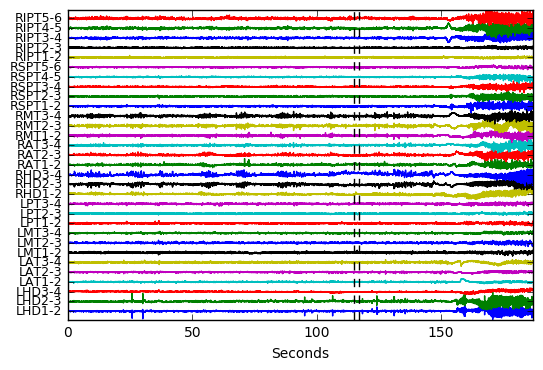

In [7]:
# Plot voltage time series and onset
[h, ax]=ief.strat_plot(ieeg,chan_labels,tpts_sec=tpts_sec)

onset_upper_bnd_sec=(onset_tpt/Sf)+1
onset_lower_bnd_sec=(onset_tpt/Sf)-1
ylim=ax.get_ylim()
plt.plot([onset_upper_bnd_sec, onset_upper_bnd_sec],ylim,'k--')
plt.plot([onset_lower_bnd_sec, onset_lower_bnd_sec],ylim,'k--')

Onset chan=RHD1-2
Contralat chan=LHD1-2


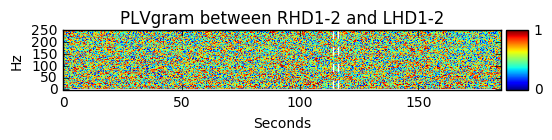

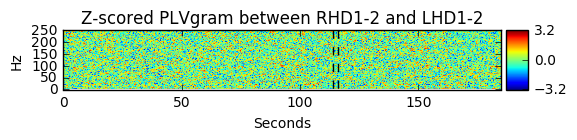

In [8]:
# Compute PLV-gram between onset and contralateral homologue using Hamming DFT
onset_chan_id=12
contra_chan_id=0
print('Onset chan=%s' % chan_labels[onset_chan_id])
print('Contralat chan=%s' % chan_labels[contra_chan_id])

wind_len=Sf # 1 Sec window
wind_step=Sf/10 # 0.1 Sec steps
#wind_step=Sf/100 # 0.1 Sec steps
data1=ieeg[onset_chan_id,:]
data2=ieeg[contra_chan_id,:]
pgram, f, pgram_sec=ief.cmpt_plvgram(data1, data2, Sf, wind_len, wind_step, tpts_sec)

# Plot raw PLV-gram
plt.figure(10)
plt.clf()
ax = plt.gca()
abs_mx = np.max(np.abs(pgram))
im=ax.imshow(pgram,vmin=0,vmax=abs_mx)
#plt.imshow(dg.asin_trans(pgram))
onset_pgram_tpt_lower=dg.find_nearest(pgram_sec,onset_lower_bnd_sec)
onset_pgram_tpt_upper=dg.find_nearest(pgram_sec,onset_upper_bnd_sec)
ylim=plt.ylim()
plt.plot([onset_pgram_tpt_upper, onset_pgram_tpt_upper],ylim,'w--')
plt.plot([onset_pgram_tpt_lower, onset_pgram_tpt_lower],ylim,'w--')
plt.ylim(ylim)
plt.ylabel('Hz')
raw_xticks=plt.xticks()
xtick_labels=list()
n_wind=len(pgram_sec)
for tick in raw_xticks[0]:
    if tick<n_wind:
        xtick_labels.append(str(int(pgram_sec[int(tick)])))
    else:
        xtick_labels.append('noData')
_=plt.xticks(raw_xticks[0],xtick_labels) #works
plt.xlim([0,len(pgram_sec)])
plt.xlabel('Seconds')
plt.gca().invert_yaxis()
plt.title('PLVgram between '+chan_labels[onset_chan_id]+' and '+chan_labels[contra_chan_id])
# plt.colorbar()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar_max_tick=int(np.floor(abs_mx*100))/100
cbar_min_tick=0
cbar = plt.colorbar(im, cax=cax, ticks=[0, cbar_max_tick])
# plt.savefig('/Users/davidgroppe/Desktop/bi_plvgram.pdf')
# print('Saving fig to disk!')

# Plot z-baselined PLV-gram
pgram_z=dg.asin_trans(pgram.copy())
ief.z_norm(pgram_z, pgram_sec, onset_lower_bnd_sec)
fig_id=11
title='Z-scored PLVgram between '+chan_labels[onset_chan_id]+' and '+chan_labels[contra_chan_id] 
fname='/Users/davidgroppe/Desktop/bi_plvgramZ.pdf'
ief.sgram_plot(pgram_z,pgram_sec,title,fname,fig_id,onset_lower_bnd_sec,onset_upper_bnd_sec)

In [9]:
# Average PLV within frequency bands

# Define frequency bands
bands=list()
bands.append((1,4)) # Delta
bands.append((4,8)) # Theta
bands.append((8,13)) # Alpha
bands.append((13,30)) # Beta
bands.append((30,50)) # Gamma
bands.append((70,100)) # High Gamma
n_band=len(bands)
band_labels=['Delta','Theta','Alpha','Beta','Gamma','High Gamma']

wind_len=Sf
wind_step=int(np.round(Sf/10))
data1=ieeg[onset_chan_id,:]
data2=ieeg[contra_chan_id,:]
bp_plv, plv_sec=ief.cmpt_bp_plv(data1, data2, Sf, wind_len, wind_step, tpts_sec, bands)

In [10]:
# Not clearly useful and takes awhile to run
#bp_plv_ptiles, ptiles_sec=ief.ptile_norm(bp_plv, plv_sec, onset_upper_bnd_sec)

Colored vertical lines indicate where there is a pre+perionset minima of each frequency band 


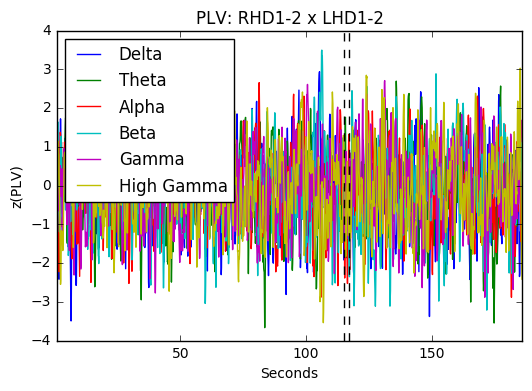

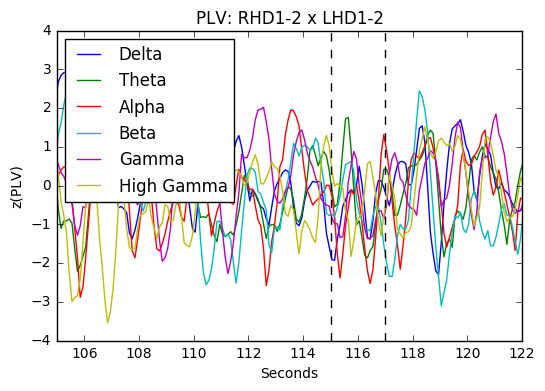

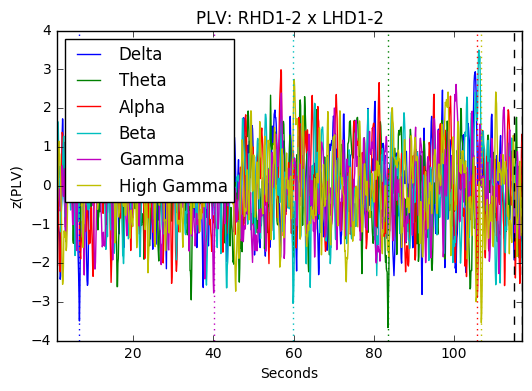

In [11]:
#Plot onset x contra PLV averaged across frequencies at all tptps
print_figs=False

ief.z_norm(bp_plv, plv_sec, onset_lower_bnd_sec) # pre-onset z-normalization, pass by reference
plt.figure(1)
plt.clf
handles=plt.plot(plv_sec,bp_plv.T)
ylim=plt.ylim()
plt.plot([onset_lower_bnd_sec, onset_lower_bnd_sec],ylim,'k--')
plt.plot([onset_upper_bnd_sec, onset_upper_bnd_sec],ylim,'k--')
plt.ylim(ylim)
plt.xlim([plv_sec[0], plv_sec[-1]])
# plt.xlim([plv_sec[0], onset_upper_bnd_sec+5])
plt.legend(handles,band_labels,loc='upper left')
plt.xlabel('Seconds')
plt.ylabel('z(PLV)')
plt.title('PLV: RHD1-2 x LHD1-2')
if print_figs==True:
    print('Saving figure!')
    plt.savefig('/Users/davidgroppe/Desktop/bp_plv_all_tpts.pdf')

# Plot just peri-onset time points
plt.figure(2)
plt.clf
handles=plt.plot(plv_sec,bp_plv.T)
ylim=plt.ylim()
plt.plot([onset_lower_bnd_sec, onset_lower_bnd_sec],ylim,'k--')
plt.plot([onset_upper_bnd_sec, onset_upper_bnd_sec],ylim,'k--')
plt.ylim(ylim)
#plt.xlim([plv_sec[0], plv_sec[-1]])
plt.xlim([onset_lower_bnd_sec-10, onset_upper_bnd_sec+5])
# plt.xlim([plv_sec[0], onset_upper_bnd_sec+5])
plt.legend(handles,band_labels,loc='upper left')
plt.xlabel('Seconds')
plt.ylabel('z(PLV)')
plt.title('PLV: RHD1-2 x LHD1-2')
if print_figs==True:
    print('Saving figure!')
    plt.savefig('/Users/davidgroppe/Desktop/bp_plv_perionset.pdf')

# TODO add vertical lines where there is a preonset minima of each frequency band    
print('Colored vertical lines indicate where there is a pre+perionset minima of each frequency band ')
plt.figure(3)
plt.clf
handles=plt.plot(plv_sec,bp_plv.T)
ylim=plt.ylim()
plt.plot([onset_lower_bnd_sec, onset_lower_bnd_sec],ylim,'k--')
plt.plot([onset_upper_bnd_sec, onset_upper_bnd_sec],ylim,'k--')
plt.ylim(ylim)
onset_pgram_tpt_upper=dg.find_nearest(plv_sec,onset_upper_bnd_sec)
for bloop in range(n_band):
    min_id=np.argmin(bp_plv[bloop,:onset_pgram_tpt_upper])
    plt.plot([plv_sec[min_id], plv_sec[min_id]],ylim,':',color=handles[bloop].get_color())
plt.xlim([plv_sec[0], onset_upper_bnd_sec])
plt.legend(handles,band_labels,loc='upper left')
plt.xlabel('Seconds')
plt.ylabel('z(PLV)')
plt.title('PLV: RHD1-2 x LHD1-2')
if print_figs==True:
    print('Saving figure!')
    plt.savefig('/Users/davidgroppe/Desktop/bp_plv_preonset.pdf')
    
# BELOW WORKS, but I'm not sure if it's useful    
# Plot just peri-onset time points converted to percentiles
# plt.figure(4)
# plt.clf
# handles=plt.plot(ptiles_sec,bp_plv_ptiles.T)
# ylim=plt.ylim()
# plt.plot([onset_lower_bnd_sec, onset_lower_bnd_sec],ylim,'k--')
# plt.plot([onset_upper_bnd_sec, onset_upper_bnd_sec],ylim,'k--')
# plt.ylim(ylim)
# #plt.xlim([plv_sec[0], plv_sec[-1]])
# plt.xlim([onset_lower_bnd_sec-10, onset_upper_bnd_sec+5])
# # plt.xlim([plv_sec[0], onset_upper_bnd_sec+5])
# plt.legend(handles,band_labels,loc='upper left')
# plt.xlabel('Seconds')
# plt.ylabel('Percentile')
# if print_figs==True:
#     print('Saving figure!')
#     plt.savefig('/Users/davidgroppe/Desktop/bp_plv_perionset_ptile.pdf')

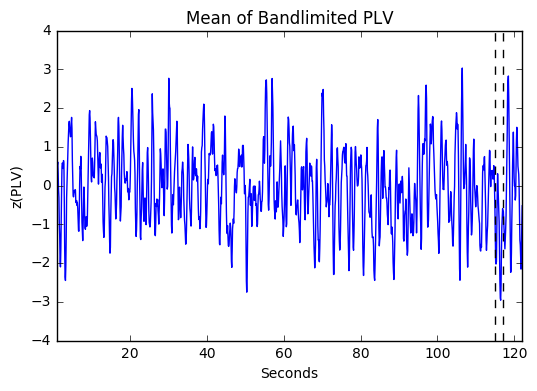

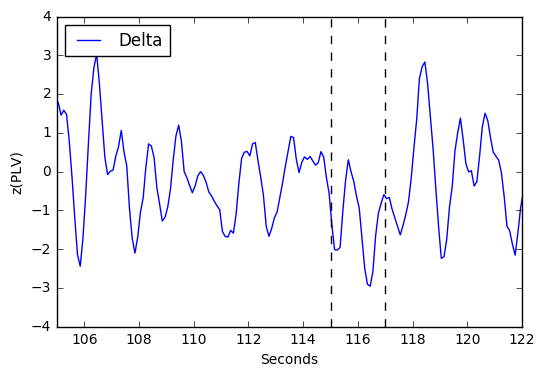

In [12]:
# Average RHD1-2 x LHD1-2 PLV across all frequencies
print_figs=False
broad_plv_vec=np.mean(bp_plv,axis=0)

broad_plv=np.reshape(broad_plv_vec,(1,len(broad_plv_vec)))
ief.z_norm(broad_plv, plv_sec, onset_lower_bnd_sec) # pre-onset z-normalization

plt.figure(1)
plt.clf
handles=plt.plot(plv_sec,broad_plv.T)
ylim=plt.ylim()
plt.plot([onset_lower_bnd_sec, onset_lower_bnd_sec],ylim,'k--')
plt.plot([onset_upper_bnd_sec, onset_upper_bnd_sec],ylim,'k--')
plt.ylim(ylim)
#plt.xlim([plv_sec[0], plv_sec[-1]])
plt.xlim([plv_sec[0], onset_upper_bnd_sec+5])
plt.title('Mean of Bandlimited PLV')
plt.xlabel('Seconds')
plt.ylabel('z(PLV)')
if print_figs==True:
    print('Saving figure!')
    plt.savefig('/Users/davidgroppe/Desktop/broad_omniplv_all_preonset.pdf')
    
# Plot just peri-onset time points
plt.figure(2)
plt.clf
handles=plt.plot(plv_sec,broad_plv.T)
ylim=plt.ylim()
plt.plot([onset_lower_bnd_sec, onset_lower_bnd_sec],ylim,'k--')
plt.plot([onset_upper_bnd_sec, onset_upper_bnd_sec],ylim,'k--')
plt.ylim(ylim)
#plt.xlim([plv_sec[0], plv_sec[-1]])
plt.xlim([onset_lower_bnd_sec-10, onset_upper_bnd_sec+5])
# plt.xlim([plv_sec[0], onset_upper_bnd_sec+5])
plt.legend(handles,band_labels,loc='upper left')
plt.xlabel('Seconds')
plt.ylabel('z(PLV)')
if print_figs==True:
    print('Saving figure!')
    plt.savefig('/Users/davidgroppe/Desktop/bp_plv_perionset.pdf')


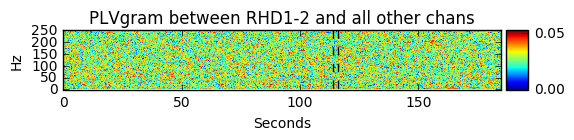

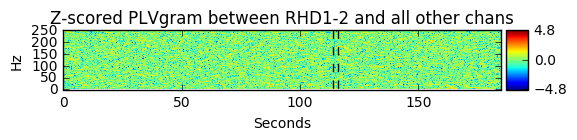

In [13]:
# Compute "omni" PLVgram (RHD1-2 vs. all others)
print_figs=False
omni_pgram, f, omni_pgram_sec=ief.omni_plvgram(ieeg, onset_chan_id, Sf, wind_len, wind_step, tpts_sec)

# Plot Omni PLVgram
plt.figure(13)
plt.clf()
ax = plt.gca()
abs_mx = np.max(np.abs(omni_pgram))
im=ax.imshow(omni_pgram,vmin=0,vmax=abs_mx)
#plt.imshow(dg.asin_trans(pgram))
onset_pgram_tpt_lower=dg.find_nearest(omni_pgram_sec,onset_lower_bnd_sec)
onset_pgram_tpt_upper=dg.find_nearest(omni_pgram_sec,onset_upper_bnd_sec)
ylim=plt.ylim()
plt.plot([onset_pgram_tpt_upper, onset_pgram_tpt_upper],ylim,'k--')
plt.plot([onset_pgram_tpt_lower, onset_pgram_tpt_lower],ylim,'k--')
plt.ylim(ylim)
plt.ylabel('Hz')
raw_xticks=plt.xticks()
xtick_labels=list()
for tick in raw_xticks[0]:
    if tick<n_wind:
        xtick_labels.append(str(int(pgram_sec[int(tick)])))
    else:
        xtick_labels.append('noData')
_=plt.xticks(raw_xticks[0],xtick_labels) #works
plt.xlim([0,len(pgram_sec)])
plt.xlabel('Seconds')
plt.gca().invert_yaxis()
plt.title('PLVgram between '+chan_labels[onset_chan_id]+' and all other chans')
# plt.colorbar()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar_max_tick=int(np.floor(abs_mx*100))/100
cbar_min_tick=0
cbar = plt.colorbar(im, cax=cax, ticks=[0, cbar_max_tick])
if print_figs==True:
    plt.savefig('/Users/davidgroppe/Desktop/omni_plvgram.pdf')
    print('Saving fig to disk!')
    

# Plot z-baselined PLV-gram
omni_pgram_z=dg.asin_trans(omni_pgram.copy())
ief.z_norm(omni_pgram_z, omni_pgram_sec, onset_lower_bnd_sec)
fig_id=14
title='Z-scored PLVgram between '+chan_labels[onset_chan_id]+' and all other chans'
if print_figs==True:
    fname='/Users/davidgroppe/Desktop/bi_plvgramZ.pdf'
else:
    fname=None
ief.sgram_plot(omni_pgram_z,omni_pgram_sec,title,fname,fig_id,onset_lower_bnd_sec,onset_upper_bnd_sec)

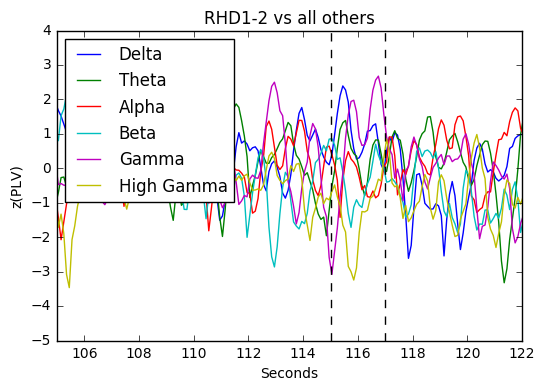

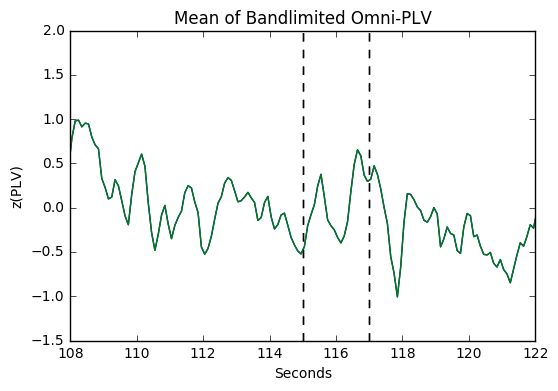

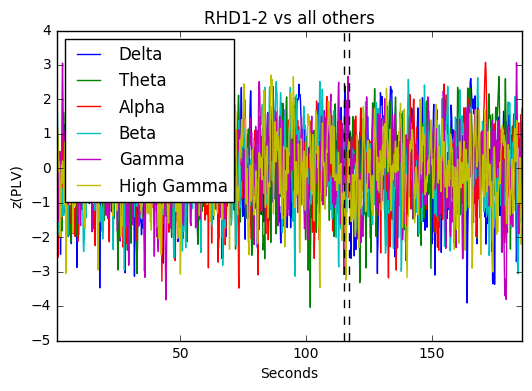

In [14]:
# Average omni PLVgram in conventional frequency bands
asin_omni=dg.asin_trans(omni_pgram)
n_plv_wind = len(plv_sec)
bp_omniplv = np.zeros((n_band, n_plv_wind))
use_ids=dict()
# figure out which freqs to use
for b in bands:
    use_ids[b] = np.logical_and(f > b[0], f < b[1])
for b_ct, b in enumerate(bands):
    bp_omniplv[b_ct, :] = np.mean(asin_omni[use_ids[b], :], axis=0)

# Plot omni plv at all time points
ief.z_norm(bp_omniplv, plv_sec, onset_lower_bnd_sec)
plt.figure(15)
plt.clf()
handles=plt.plot(plv_sec,bp_omniplv.T)
ylim=plt.ylim()
plt.plot([onset_lower_bnd_sec, onset_lower_bnd_sec],ylim,'k--')
plt.plot([onset_upper_bnd_sec, onset_upper_bnd_sec],ylim,'k--')
plt.ylim(ylim)
plt.xlim([plv_sec[0], plv_sec[-1]])
# plt.xlim([plv_sec[0], onset_upper_bnd_sec+5])
plt.legend(handles,band_labels,loc='upper left')
plt.xlabel('Seconds')
plt.ylabel('z(PLV)')
plt.title('RHD1-2 vs all others')
if print_figs==True:
    print('Saving figure!')
    plt.savefig('/Users/davidgroppe/Desktop/bp_plv_all_tpts.pdf')

# Plot omni-PLV just peri-onset time points
plt.figure(16)
plt.clf()
handles=plt.plot(plv_sec,bp_omniplv.T)
ylim=plt.ylim()
plt.plot([onset_lower_bnd_sec, onset_lower_bnd_sec],ylim,'k--')
plt.plot([onset_upper_bnd_sec, onset_upper_bnd_sec],ylim,'k--')
plt.ylim(ylim)
#plt.xlim([plv_sec[0], plv_sec[-1]])
plt.xlim([onset_lower_bnd_sec-10, onset_upper_bnd_sec+5])
# plt.xlim([plv_sec[0], onset_upper_bnd_sec+5])
plt.legend(handles,band_labels,loc='upper left')
plt.xlabel('Seconds')
plt.ylabel('z(PLV)')
plt.title('RHD1-2 vs all others')
if print_figs==True:
    print('Saving figure!')
    plt.savefig('/Users/davidgroppe/Desktop/bp_omniplv_perionset.pdf')
    
# Average across freq bands
broad_omniplv=np.mean(bp_omniplv,axis=0)
plt.figure(17)
plt.plot(plv_sec,broad_omniplv.T)
ylim=plt.ylim()
plt.plot([onset_lower_bnd_sec, onset_lower_bnd_sec],ylim,'k--')
plt.plot([onset_upper_bnd_sec, onset_upper_bnd_sec],ylim,'k--')
plt.ylim(ylim)
#plt.xlim([plv_sec[0], plv_sec[-1]])
plt.xlim([plv_sec[0], onset_upper_bnd_sec+5])
plt.title('Mean of Bandlimited Omni-PLV')
plt.xlabel('Seconds')
plt.ylabel('z(PLV)')
if print_figs==True:
    print('Saving figure!')
    plt.savefig('/Users/davidgroppe/Desktop/broad_omniplv_all_preonset.pdf')
    
# Average across freq bands
broad_omniplv=np.mean(bp_omniplv,axis=0)
plt.figure(17)
plt.plot(plv_sec,broad_omniplv.T)
ylim=plt.ylim()
plt.plot([onset_lower_bnd_sec, onset_lower_bnd_sec],ylim,'k--')
plt.plot([onset_upper_bnd_sec, onset_upper_bnd_sec],ylim,'k--')
plt.ylim(ylim)
#plt.xlim([plv_sec[0], plv_sec[-1]])
plt.xlim([onset_lower_bnd_sec-7, onset_upper_bnd_sec+5])
plt.title('Mean of Bandlimited Omni-PLV')
plt.xlabel('Seconds')
plt.ylabel('z(PLV)')
if print_figs==True:
    print('Saving figure!')
    plt.savefig('/Users/davidgroppe/Desktop/broad_omniplv_all_preonset.pdf')

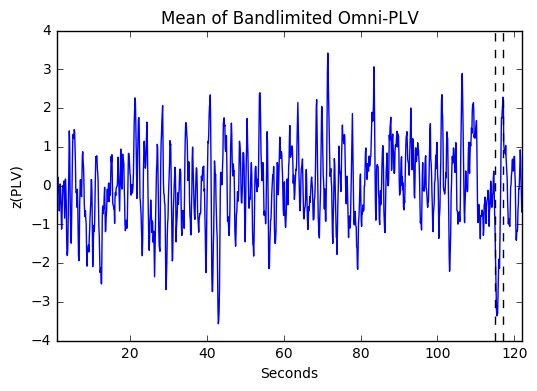

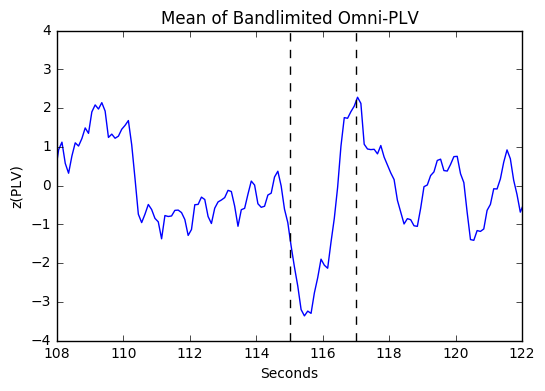

In [15]:
# Another way to average omni-PLVgram across all frequencies
# Simple average across 0-200 HZ
print_figs=False

use_ids=np.argwhere(f<(Sf*.4))
broad_omni_plv2=np.mean(dg.asin_trans(omni_pgram[use_ids,:]),axis=0)
ief.z_norm(broad_omni_plv2, plv_sec, onset_lower_bnd_sec) # pre-onset z-normalization

plt.figure(21)
plt.plot(plv_sec,broad_omni_plv2.T)
ylim=plt.ylim()
plt.plot([onset_lower_bnd_sec, onset_lower_bnd_sec],ylim,'k--')
plt.plot([onset_upper_bnd_sec, onset_upper_bnd_sec],ylim,'k--')
plt.ylim(ylim)
#plt.xlim([plv_sec[0], plv_sec[-1]])
plt.xlim([plv_sec[0], onset_upper_bnd_sec+5])
plt.title('Mean of Bandlimited Omni-PLV')
plt.xlabel('Seconds')
plt.ylabel('z(PLV)')
if print_figs==True:
    print('Saving figure!')
    plt.savefig('/Users/davidgroppe/Desktop/broad_omniplv_all_preonset.pdf')
    
plt.figure(22)
plt.plot(plv_sec,broad_omni_plv2.T)
ylim=plt.ylim()
plt.plot([onset_lower_bnd_sec, onset_lower_bnd_sec],ylim,'k--')
plt.plot([onset_upper_bnd_sec, onset_upper_bnd_sec],ylim,'k--')
plt.ylim(ylim)
#plt.xlim([plv_sec[0], plv_sec[-1]])
plt.xlim([onset_lower_bnd_sec-7, onset_upper_bnd_sec+5])
plt.title('Mean of Bandlimited Omni-PLV')
plt.xlabel('Seconds')
plt.ylabel('z(PLV)')
if print_figs==True:
    print('Saving figure!')
    plt.savefig('/Users/davidgroppe/Desktop/broad_omniplv_all_preonset.pdf')

['RAT2-3', 'LPT2-3', 'LMT2-3']
[16, 10, 7]
[5, 8, 2]
5.0
8.0
2.0


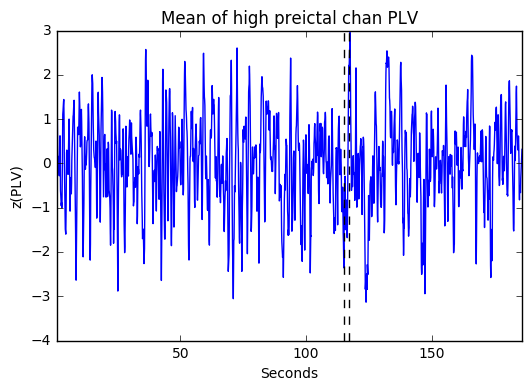

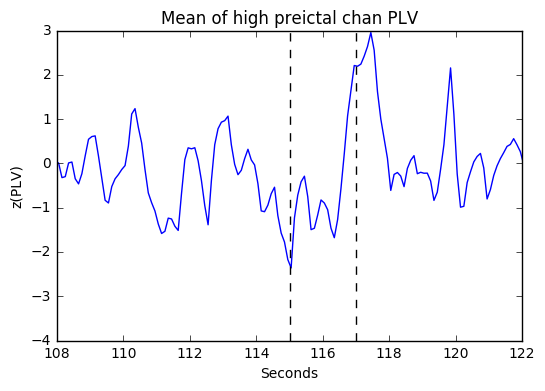

In [25]:
# Average PLV at 3 channels and frequencies that have relatively high PLV with RHD1-2
# RAT2-3 @ 5 Hz
# LPT2-3 @ 8 Hz
# LMT2-3 @ 2 Hz
# See find_chans_with_high_connectivity.ipynb for code that found these channels & frequencies
print_figs=False

# Get Indices of channels to use
use_chans=['RAT2-3','LPT2-3','LMT2-3']
use_freqs=[5,8,2]
use_chan_ids=[]
n_chan=len(chan_labels)
for a in range(len(use_chans)):
    for b in range(n_chan):
        if chan_labels[b]==use_chans[a]:
            use_chan_ids.append(b)
print(use_chans)
print(use_chan_ids)
print(use_freqs)

wind_len=Sf # 1 Sec window
wind_step=Sf/10 # 0.1 Sec steps
for a in range(len(use_chans)):
    pgram, f, plv_sec=ief.cmpt_plvgram(ieeg[onset_chan_id,:], ieeg[use_chan_ids[a],:],
                                         Sf, wind_len, wind_step, tpts_sec)
    f_id=dg.find_nearest(f,use_freqs[a])
    print(f[f_id])
    if a==0:
        mn_plv=dg.asin_trans(pgram[f_id,:])
    else:
        mn_plv+=dg.asin_trans(pgram[f_id,:])
mn_plv=mn_plv/len(use_chans)

# pre-onset z-normalization
mn_plv=np.reshape(mn_plv,(1,len(mn_plv)))
ief.z_norm(mn_plv, plv_sec, onset_lower_bnd_sec) 

plt.figure(21)
plt.plot(plv_sec,mn_plv.T)
ylim=plt.ylim()
plt.plot([onset_lower_bnd_sec, onset_lower_bnd_sec],ylim,'k--')
plt.plot([onset_upper_bnd_sec, onset_upper_bnd_sec],ylim,'k--')
plt.ylim(ylim)
plt.xlim([plv_sec[0], plv_sec[-1]])
#plt.xlim([plv_sec[0], onset_upper_bnd_sec+5])
plt.title('Mean of high preictal chan PLV')
plt.xlabel('Seconds')
plt.ylabel('z(PLV)')
if print_figs==True:
    print('Saving figure!')
    #plt.savefig('/Users/davidgroppe/Desktop/select_high_plv_all_preonset.pdf')
    
plt.figure(22)
plt.plot(plv_sec,mn_plv.T)
ylim=plt.ylim()
plt.plot([onset_lower_bnd_sec, onset_lower_bnd_sec],ylim,'k--')
plt.plot([onset_upper_bnd_sec, onset_upper_bnd_sec],ylim,'k--')
plt.ylim(ylim)
#plt.xlim([plv_sec[0], plv_sec[-1]])
plt.xlim([onset_lower_bnd_sec-7, onset_upper_bnd_sec+5])
plt.title('Mean of high preictal chan PLV')
plt.xlabel('Seconds')
plt.ylabel('z(PLV)')
if print_figs==True:
    print('Saving figure!')
    #plt.savefig('/Users/davidgroppe/Desktop/elect_high_plv_all_preonset_zoom.pdf')
